# [EDA] Scalable Unsupervised Machine Learning Approaches for Discovering Latent Customer Segments in Online Retail Data

- Author: Joleil Villena (joleilvillena.tech@gmail.com)
- Organization: Asian Institute Management
- Purpose: Capstone Project for Postgraduate Diploma in Artificial Intelligence and Machine Learning - Data Cleaning for EDA and Model Development

<b>Original Data Set</b>

| Information             | Details |
|-------------------------|---------|
| Name                    | Online Retail |
| Creation Date           | Donated on 11/5/2015 |
| Source                  | UC Irvine Machine Learning Repository |
| Link                    | https://archive.ics.uci.edu/dataset/352/online+retail |
| Description             | Transactional data set containing all transactions between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail company |
| Data Set Characteristics| Multivariate, Sequential, Time-Series |
| Subject Area            | Business |
| Associated Tasks        | Classification, Clustering |
| Feature Type            | Integer, Real |
| Instances               | 541,909 |
| Features                | 6 |
| Additional Information  | The company mainly sells unique all-occasion gifts. Many customers are wholesalers. |

<b>Cleaning Steps</b>

- Renamed columns
- Correct formatting of the invoice_date column to datetime data type
- Renamed some values in the country column
- Dropped transactions with null customer_id
- Dropped transactions with non-positive unit_price
- Dropped transactions with negative quantity

Notes:
- Potential outliers in transaction quantities were retained, as larger purchase volumes are more representative of wholesale customers rather than data errors.
- Unit prices were not treated as outliers since price variation reflects the retailer’s pricing strategy, not anomalous observations.

## Import Libraries

In [1]:
# Import libraries
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from collections import defaultdict
from IPython.display import display

%matplotlib inline

import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

## Read Data
| Variable Name | Role     | Type        | Description                                                                                     | Units    | Missing Values |
|---------------|---------|------------|-------------------------------------------------------------------------------------------------|---------|----------------|
| invoice_no     | ID      | Categorical | A 6-digit integral number uniquely assigned to each transaction. If this code starts with 'C', it indicates a cancellation |         | no             |
| stock_code     | ID      | Categorical | A 5-digit integral number uniquely assigned to each distinct product                             |         | no             |
| description   | Feature | Categorical | Product name                                                                                     |         | no             |
| quantity      | Feature | Integer     | The quantities of each product (item) per transaction                                            |         | no             |
| invoice_date   | Feature | Date        | The day and time when each transaction was generated                                             |         | no             |
| unit_price     | Feature | Continuous  | Product price per unit                                                                           | GBP | no             |
| customer_id    | Feature | Categorical | A 5-digit integral number uniquely assigned to each customer                                     |         | no             |
| country       | Feature | Categorical | The name of the country where each customer resides                                              |         | no             |

Source: UC Irvine Machine Learning Repository https://archive.ics.uci.edu/dataset/352/online+retail 


In [2]:
# Read and view data set
cleaned_data = pd.read_excel("../data/online_retail_cleaned.xlsx")
cleaned_data

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
397875,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
397876,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
397877,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
397878,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [3]:
cleaned_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397880 entries, 0 to 397879
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoice_number  397880 non-null  int64         
 1   stock_code      397880 non-null  object        
 2   description     397880 non-null  object        
 3   quantity        397880 non-null  int64         
 4   invoice_date    397880 non-null  datetime64[ns]
 5   unit_price      397880 non-null  float64       
 6   customer_id     397880 non-null  int64         
 7   country         397880 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 24.3+ MB


In [4]:
cleaned_data[['quantity', 'unit_price']].describe()

,quantity,unit_price
count,397880.000000,397880.000000
mean,12.988358,3.116519
std,179.332672,22.097986
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [5]:
df = cleaned_data.copy()

## Exploratory Data Analysis
### Transaction Count and Sales Amount

In [6]:
# Calculate amount
# amount = unit_price * quantity
df['amount'] = df['quantity'] * df['unit_price']

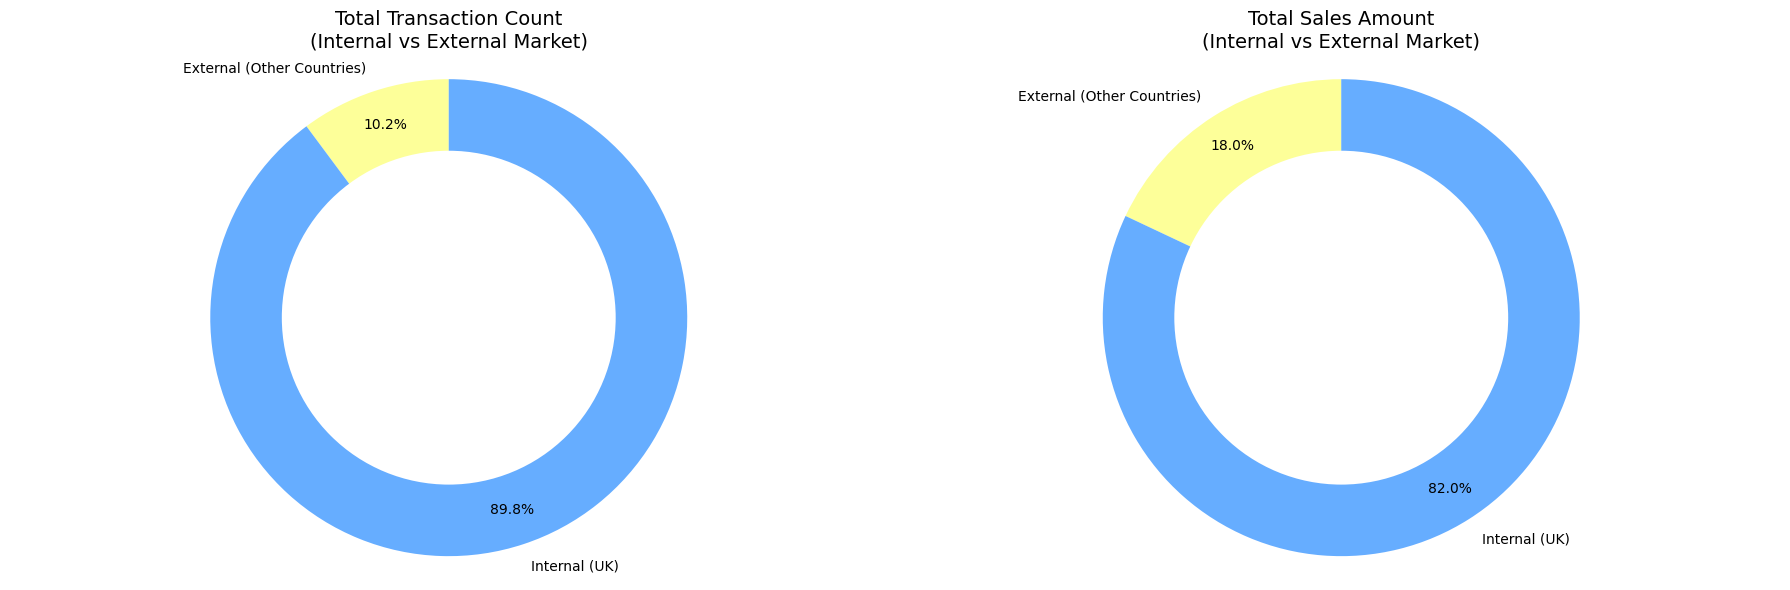

In [8]:
# Transaction Count and Transaction Amount

# Internal vs External
df['internal'] = df['country'].apply( lambda x: 'Internal (UK)' if x == 'United Kingdom' else 'External (Other Countries)' )

# Aggregate data for market types
market_txns = df.groupby('internal')['invoice_number'].nunique()
market_sales = df.groupby('internal')['amount'].sum()

# Create figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --------------------------------------------------
# LEFT: Transaction Count Doughnut
# --------------------------------------------------
axes[0].pie(
    market_txns,
    labels=market_txns.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=["#fdff99", "#66adff"]
)
axes[0].add_artist(plt.Circle((0, 0), 0.70, fc='white')) # Doughnut hole
axes[0].set_title('Total Transaction Count\n(Internal vs External Market)', fontsize=14)
axes[0].axis('equal')

# --------------------------------------------------
# RIGHT: Transaction Amount Doughnut
# --------------------------------------------------
axes[1].pie(
    market_sales,
    labels=market_sales.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=['#fdff99', '#66adff']
)
axes[1].add_artist(plt.Circle((0, 0), 0.70, fc='white')) # Doughnut hole
axes[1].set_title('Total Sales Amount\n(Internal vs External Market)', fontsize=14)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

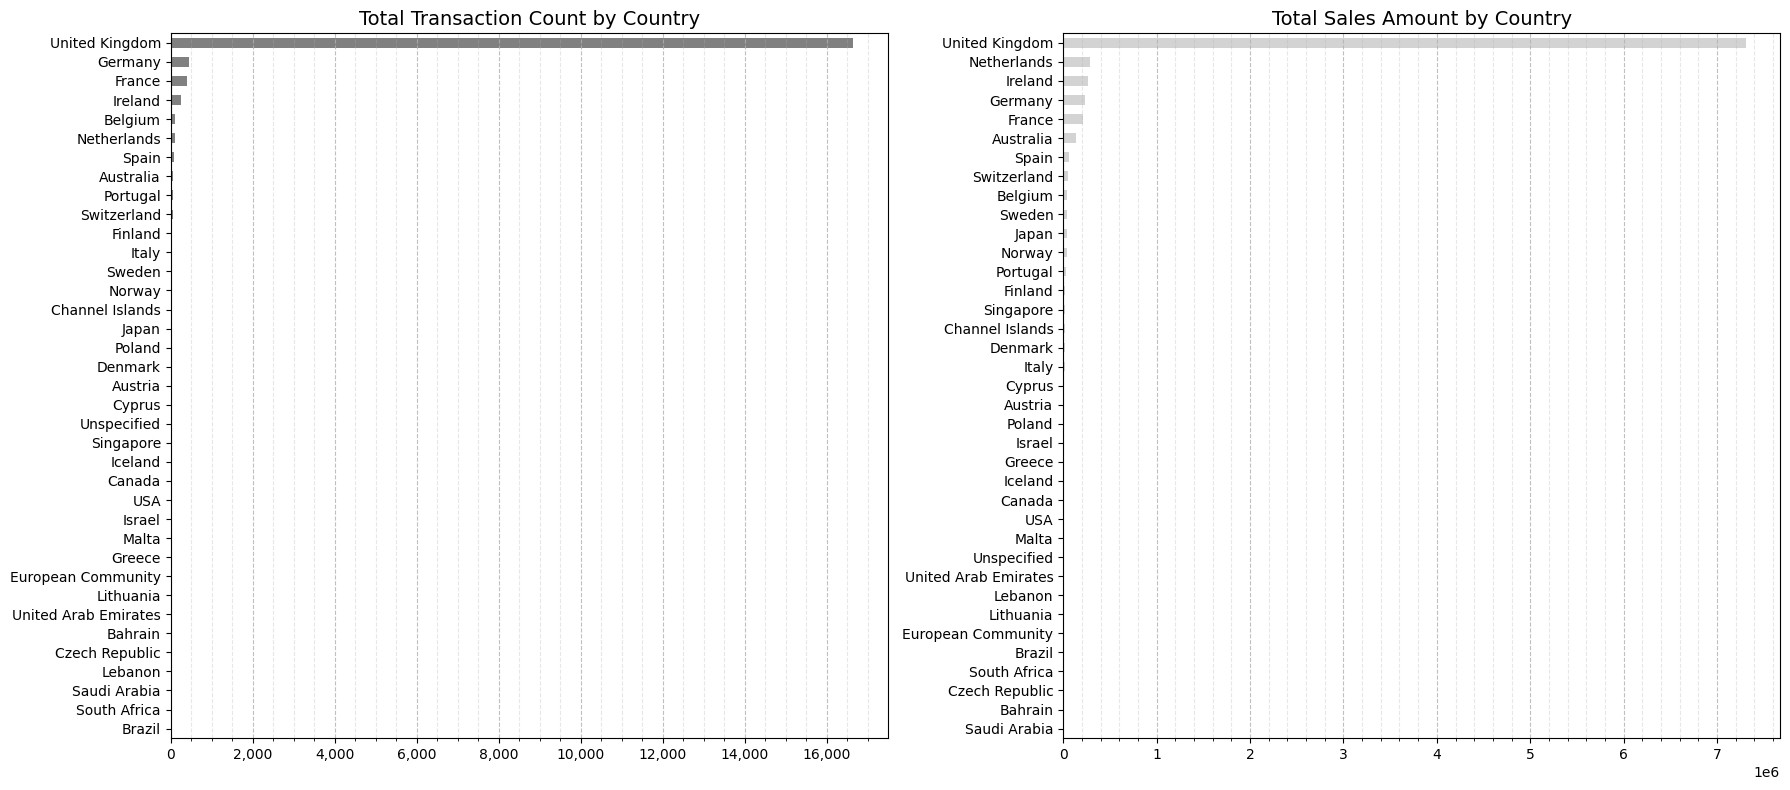

In [9]:
# Transaction Count and Transaction Amount

# Aggregate data for countries
country_txns = df.groupby('country')['invoice_number'].nunique().sort_values(ascending=True)
country_sales = df.groupby('country')['amount'].sum().sort_values(ascending=True)

# Create figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --------------------------------------------------
# LEFT: Transaction Count by Country
# --------------------------------------------------
country_txns.plot(kind='barh', ax=axes[0], color='grey')
axes[0].set_title('Total Transaction Count by Country', fontsize=14)

# Format x-axis labels with commas
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

axes[0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0].xaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
axes[0].xaxis.grid(True, which='major', linestyle='--', alpha=0.8)
axes[0].set_ylabel('')
# axes[0].set_xlabel('')

# --------------------------------------------------
# RIGHT: Sales Amount by Country
# --------------------------------------------------
country_sales.plot(kind='barh', ax=axes[1], color='lightgrey')
axes[1].set_title('Total Sales Amount by Country', fontsize=14)
axes[1].xaxis.set_minor_locator(AutoMinorLocator())
axes[1].xaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
axes[1].xaxis.grid(True, which='major', linestyle='--', alpha=0.8)
axes[1].set_ylabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

### Customers

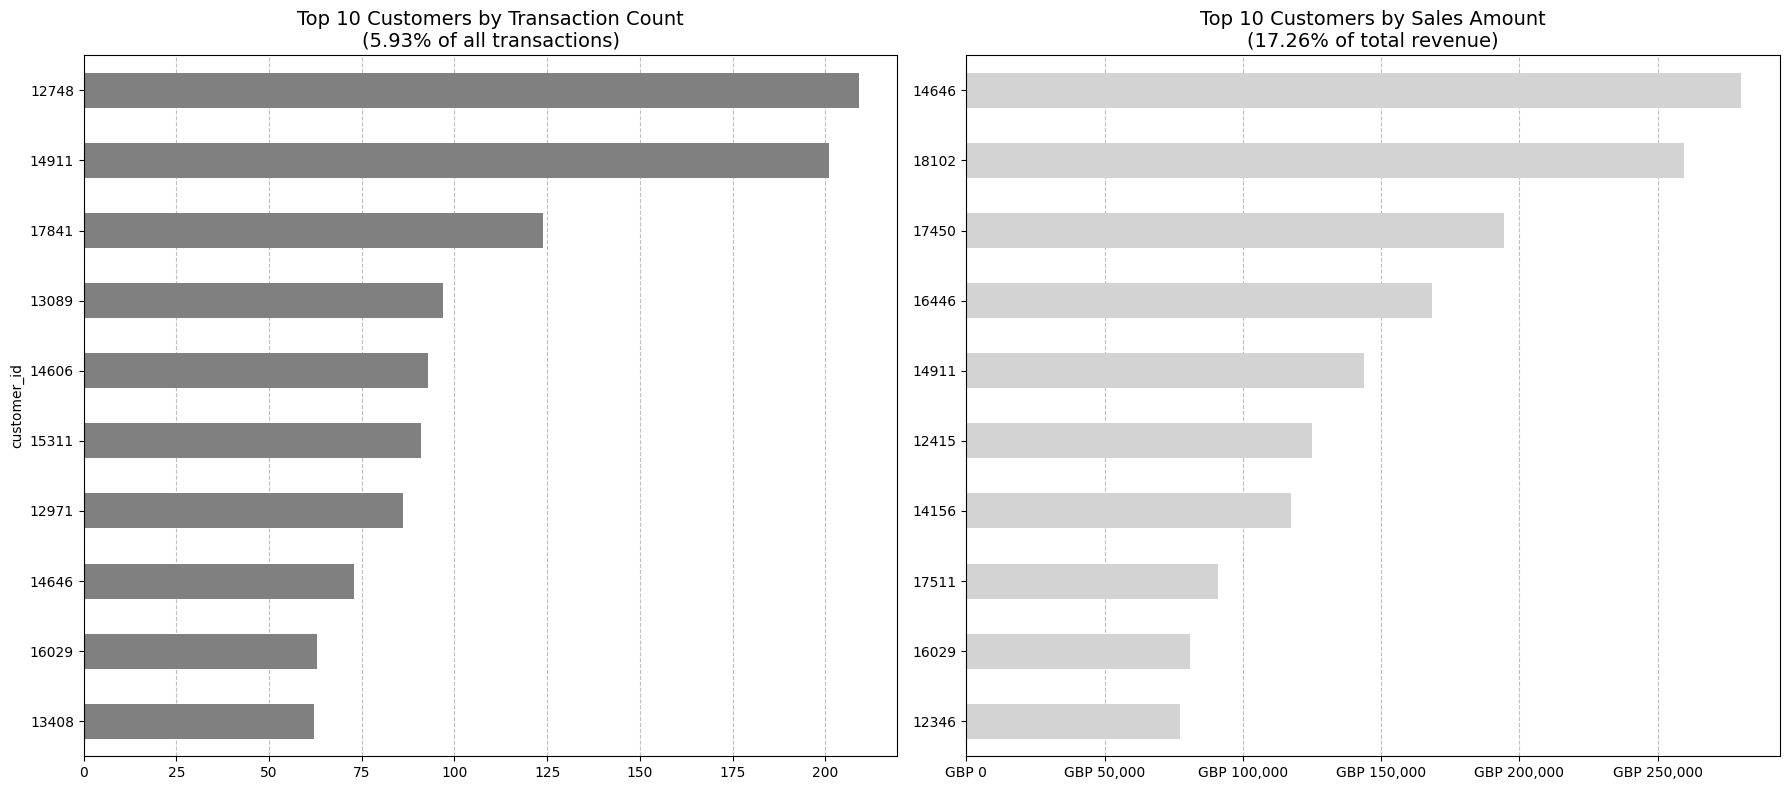

In [10]:
# Top Customers
# Prepare Data
customer_stats = df.groupby('customer_id').agg({
    'amount': 'sum',
    'invoice_number': 'nunique' # Counts unique transactions
}).rename(columns={'invoice_number': 'txn_count'})

total_sales_overall = customer_stats['amount'].sum()
total_txns_overall = customer_stats['txn_count'].sum()

# Get Top 10 for both metrics
top_10_amount = customer_stats['amount'].sort_values(ascending=False).head(10)
top_10_freq = customer_stats['txn_count'].sort_values(ascending=False).head(10)

# Calculate Percentages
pct_sales = (top_10_amount.sum() / total_sales_overall) * 100
pct_freq = (top_10_freq.sum() / total_txns_overall) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --------------------------------------------------
# LEFT: Top 10 by Transaction Frequency
# --------------------------------------------------
top_10_amount.sort_values().plot(kind='barh', ax=axes[1], color='lightgrey')
axes[0].set_title(f'Top 10 Customers by Transaction Count\n({pct_freq:.2f}% of all transactions)', fontsize=14)
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# axes[0].set_ylabel('Customer ID') 
axes[0].set_xlabel('')

# --------------------------------------------------
# RIGHT: Top 10 by Sales Amount 
# --------------------------------------------------
top_10_freq.sort_values().plot(kind='barh', ax=axes[0], color='grey')
axes[1].set_title(f'Top 10 Customers by Sales Amount\n({pct_sales:.2f}% of total revenue)', fontsize=14)
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('GBP {x:,.0f}'))
axes[1].set_ylabel('')
axes[1].set_xlabel('')

# Add grids for better scannability
for ax in axes:
    ax.xaxis.grid(True, linestyle='--', alpha=0.8)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Products

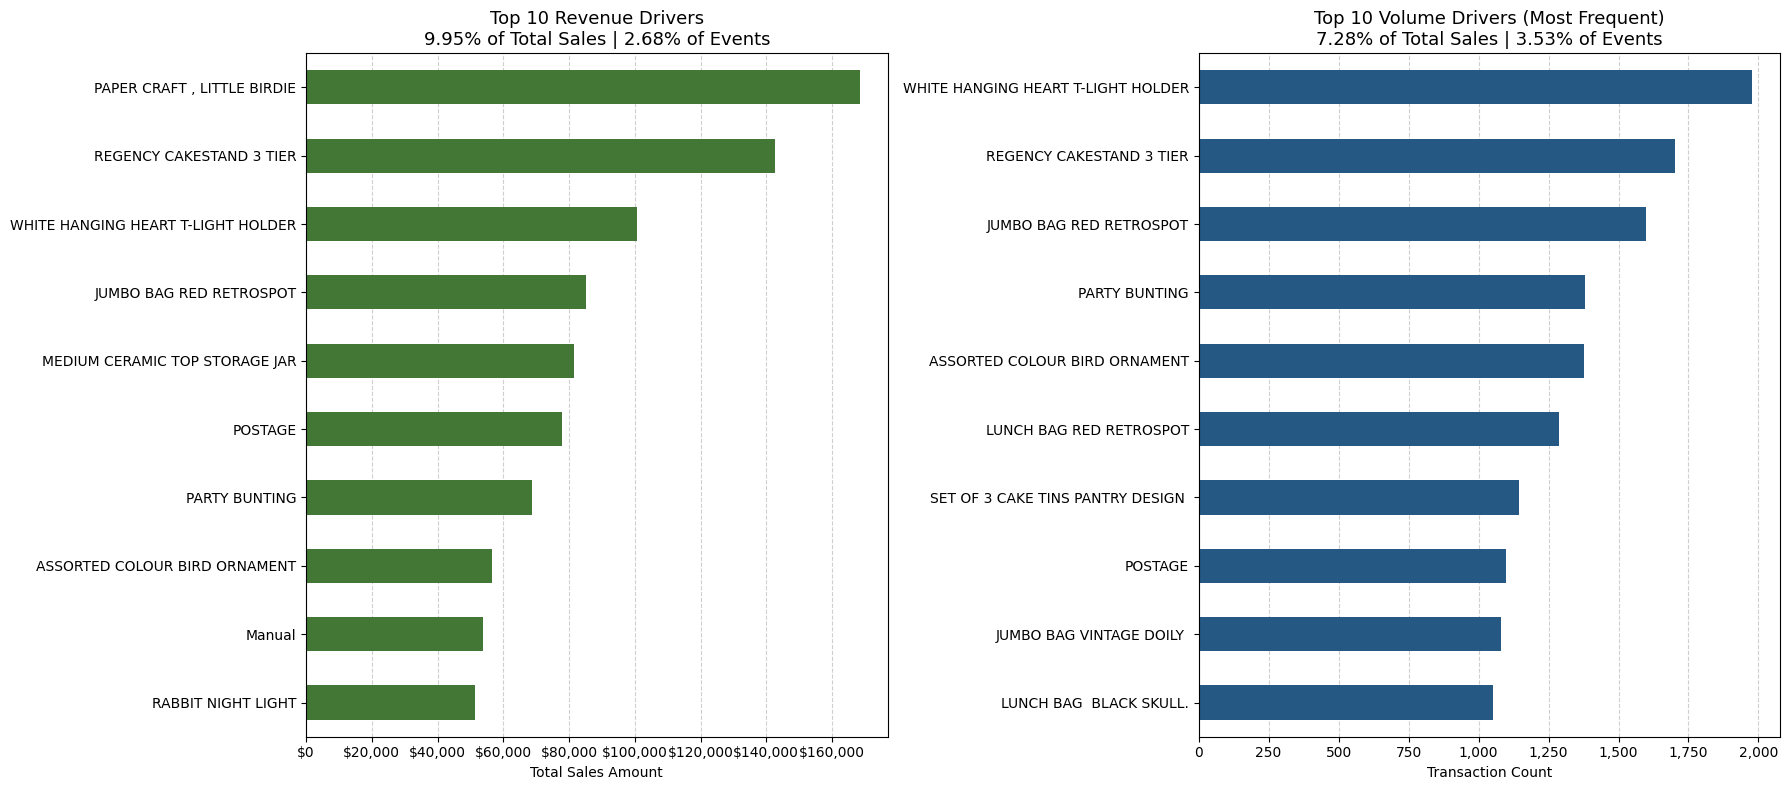

In [11]:

# Prepare Product Data
product_stats = df.groupby('description').agg({
    'amount': 'sum',
    'invoice_number': 'nunique'
}).rename(columns={'invoice_number': 'txn_count'})

total_sales_sum = product_stats['amount'].sum()
total_txn_sum = product_stats['txn_count'].sum()

# Identify Top 10 for each category
top_10_val = product_stats['amount'].sort_values(ascending=False).head(10)
top_10_vol = product_stats['txn_count'].sort_values(ascending=False).head(10)

# Calculate dual-metrics for titles
# Pct for Top 10 Revenue Drivers
val_drivers_rev_pct = (top_10_val.sum() / total_sales_sum) * 100
val_drivers_vol_pct = (product_stats.loc[top_10_val.index, 'txn_count'].sum() / total_txn_sum) * 100

# Pct for Top 10 Volume Drivers
vol_drivers_rev_pct = (product_stats.loc[top_10_vol.index, 'amount'].sum() / total_sales_sum) * 100
vol_drivers_vol_pct = (top_10_vol.sum() / total_txn_sum) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --------------------------------------------------
# LEFT: Top 10 by Sales Amount (Revenue)
# --------------------------------------------------
top_10_val.sort_values().plot(kind='barh', ax=axes[0], color="#437736")
axes[0].set_title(
    f'Top 10 Revenue Drivers\n{val_drivers_rev_pct:.2f}% of Total Sales | {val_drivers_vol_pct:.2f}% of Events', 
    fontsize=13
)
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axes[0].set_ylabel('')
axes[0].set_xlabel('Total Sales Amount')


# --------------------------------------------------
# RIGHT: Top 10 by Transaction Count (Volume)
# --------------------------------------------------
top_10_vol.sort_values().plot(kind='barh', ax=axes[1], color="#255983")
axes[1].set_title(
    f'Top 10 Volume Drivers (Most Frequent)\n{vol_drivers_rev_pct:.2f}% of Total Sales | {vol_drivers_vol_pct:.2f}% of Events', 
    fontsize=13
)
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].set_ylabel('')
axes[1].set_xlabel('Transaction Count')

# Cleanup
for ax in axes:
    ax.xaxis.grid(True, linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

---